In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

In [5]:
L_rng_bins = 64
M_antennas = 8
N_chirps = 64

angle_range = [-50,50]
I_angle_bins = 64

In [6]:
#compute the angles that the AoA response should be measured at
step = (angle_range[1] - angle_range[0]) / I_angle_bins
angles_deg = np.arange(angle_range[0],angle_range[1],step)
angles_rad = np.deg2rad(angles_deg)

#functions to compute the a_phi vector at a given angle
def compute_spatial_signature(angle_rad):

    indicies = np.arange(0,M_antennas,dtype=np.float32)
    spatial_signature = np.exp(1j * np.pi * indicies * np.sin(angle_rad))

    return spatial_signature

def compute_spatial_signatures(angles_rad):

    spatial_signatures = np.zeros(shape=(I_angle_bins,M_antennas,1),dtype=np.complex_)

    for i in range(len(angles_rad)):
        spatial_signatures[i,:,0] = compute_spatial_signature(angles_rad[i])
        # spatial_signatures[:,i] = spatial_signature
    
    return spatial_signatures

a_phi = compute_spatial_signatures(angles_rad)
a_phi_H = np.conj(np.transpose(a_phi,axes=(0,2,1)))

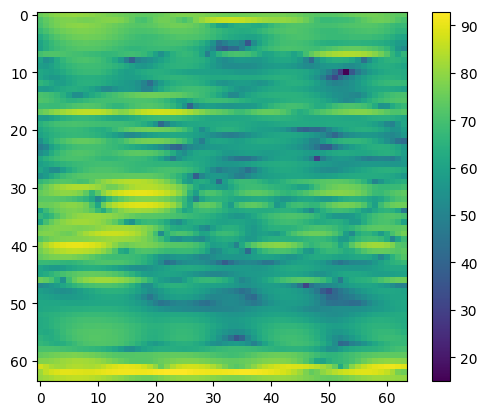

In [22]:
#get the ADC data cube
#adc_data_cube = np.random.rand(L_rng_bins,M_antennas,N_chirps) + 1j * np.random.rand(L_rng_bins,M_antennas,N_chirps)
adc_data_cube = np.load("/home/cpsl/data/radar/frame_10000.npy")

#convert to (range_bin, antenna, chirp)
adc_data_cube = np.transpose(adc_data_cube,axes=(1,0,2))

rng_fft = np.fft.fft(adc_data_cube,axis=0)

# plt.imshow(20 * np.log10(np.abs(rng_fft[:,:,0])))

# optional (for showing the FFT-based range azimuth response)
az_fft = 20 * np.log10(np.abs(np.fft.fftshift(np.fft.fft(rng_fft, axis=1,n=64),axes=1)))
plt.imshow(np.flip(az_fft[:,:,0],axis=0))
plt.colorbar()

In [17]:
#computing bartlet response
def compute_bartlet(adc_data_cube: np.ndarray):
    
    #compute the range_fft
    # rng_fft = np.fft.fftshift(np.fft.fft(adc_data_cube,axis=0),axes=1)
    rng_fft = np.fft.fft(adc_data_cube,axis=0)

    p_bartlet = np.zeros(shape=(L_rng_bins,I_angle_bins),dtype=np.complex_)

    for l in range(L_rng_bins):
        # x_n = np.transpose(rng_fft[l,:,:,np.newaxis],axes=(1,0,2))
        x_n = np.expand_dims(np.transpose(rng_fft[l,:,:]),axis=-1) #NxMx1
        x_n_h = np.conj(np.transpose(x_n,axes=(0,2,1)))

        Rxx = np.mean(np.matmul(x_n,x_n_h),axis=0)

        p = a_phi_H @ Rxx @ a_phi

        p_bartlet[l,:] = p[:,0,0]

    return 20 * np.log10(np.abs(p_bartlet))

p_bartlet = compute_bartlet(adc_data_cube)

In [9]:
#computing Capon response:
def compute_capon(adc_data_cube: np.ndarray):
    
    #compute the range_fft
    rng_fft = np.fft.fftshift(np.fft.fft(adc_data_cube,axis=0),axes=1)

    p_capon = np.zeros(shape=(L_rng_bins,I_angle_bins),dtype=np.complex_)

    for l in range(L_rng_bins):
        # x_n = np.transpose(rng_fft[l,:,:,np.newaxis],axes=(1,0,2))
        x_n = np.expand_dims(np.transpose(rng_fft[l,:,:]),axis=-1) #NxMx1
        x_n_h = np.conj(np.transpose(x_n,axes=(0,2,1)))

        Rxx = np.mean(np.matmul(x_n,x_n_h),axis=0)
        Rxx_inv = np.linalg.inv(Rxx)
        p = a_phi_H @ Rxx_inv @ a_phi

        p_capon[l,:] = 1.0 / p[:,0,0]

    return 20 * np.log10(np.abs(p_capon))

p_capon = compute_capon(adc_data_cube)

In [10]:
#conducting a speed test

runs = 100

start = time.perf_counter()
for i in range(runs):
    p_capon = compute_capon(adc_data_cube)
end = time.perf_counter()

print("execution time: {}ms".format(1e3*(end-start)/runs))

execution time: 10.113167099916609ms


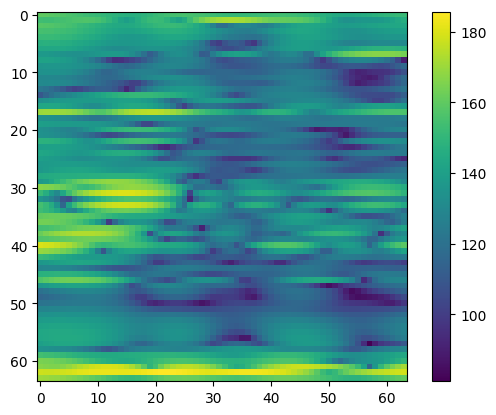

In [18]:
plt.imshow(np.flip(p_bartlet,axis=0))
plt.colorbar()